# Experiment with interactions  


In [126]:
import warnings
warnings.filterwarnings('ignore')

In [127]:
import pandas as pd 
from datetime import datetime
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [128]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [129]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [130]:
#drop yr_renovated too many outliers 
df = df.drop('yr_renovated',axis=1)

print(df.view.value_counts())
print(df.waterfront.value_counts())

# fill the view and waterfront with 0 
df = df.fillna(value={'view':0,
                      'waterfront':0})

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64
0.0    19075
1.0      146
Name: waterfront, dtype: int64


In [131]:
df = df[df.bedrooms < 7]
df = df[df.bathrooms < 5]
df = df[df.sqft_living < 10000]

In [132]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [133]:
len(df[df.sqft_living > 7000])

6

In [134]:
df.sqft_living.mean()

2064.505633671664

# Exploring interactions

## sqft living and waterfront 

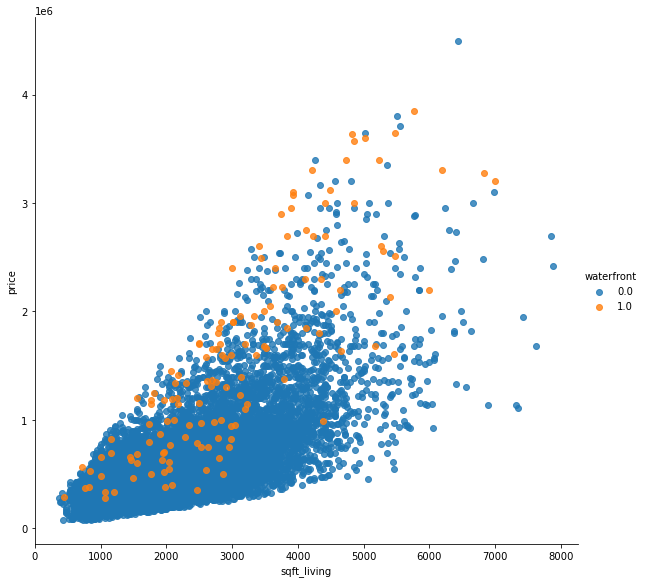

In [135]:
sns.lmplot(x = 'sqft_living',
          y= 'price',
          hue='waterfront',
          data=df,
          fit_reg=False,
          height=8)

In [136]:
waterfront = df[df.waterfront == 1]
no_waterfront = df[df.waterfront == 0]
print(len(waterfront))

140


In [137]:
print(len(no_waterfront))

21338


In [138]:
regression1 = LinearRegression()
regression2 = LinearRegression()

waterfront_sqft_living = waterfront.sqft_living.values.reshape(-1,1)
no_waterfront_sqft_living = no_waterfront.sqft_living.values.reshape(-1,1)

model1 = regression1.fit(waterfront_sqft_living, waterfront.price)
model2 = regression2.fit(no_waterfront_sqft_living, no_waterfront.price)

pred1 = model1.predict(waterfront_sqft_living)
pred2 = model2.predict(no_waterfront_sqft_living)

print(regression1.coef_)
print(regression2.coef_)
# different slopes for waterfront or no waterfront 

[566.08337074]
[253.27492952]


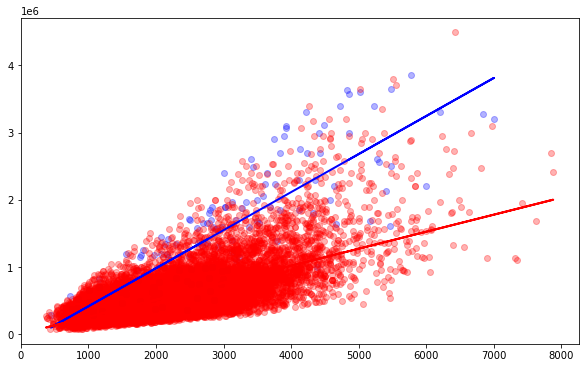

In [139]:
plt.figure(figsize=(10,6))
plt.scatter(waterfront_sqft_living, waterfront['price'], alpha = 0.3, label='has waterfront', color='blue')
plt.scatter(no_waterfront_sqft_living, no_waterfront['price'], alpha=0.3, label='no waterfront', color='red')
plt.plot(waterfront_sqft_living, pred1, color='blue', linewidth=2)
plt.plot(no_waterfront_sqft_living, pred2, color='red', linewidth=2)


In [140]:
# baseline 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 

data_fin = df[['price','bathrooms','grade','sqft_living','sqft_living15','waterfront']]
X = data_fin.drop('price', axis=1)
y = data_fin[['price']]
regression = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
baseline

0.5634028408824818

In [141]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
X_interact = X.copy()
X_interact['sqft_living_waterfront'] = X['sqft_living'] * X['waterfront']
interact_waterfront_sqft = np.mean(cross_val_score(regression, X_interact, y, scoring='r2', cv=crossvalidation))
interact_waterfront_sqft

0.5728090177182125

In [142]:
model = sm.OLS.from_formula('price ~ sqft_living + bathrooms + waterfront', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     7344.
Date:                Sun, 29 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:27:28   Log-Likelihood:            -2.9643e+05
No. Observations:               21478   AIC:                         5.929e+05
Df Residuals:                   21474   BIC:                         5.929e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3192.1451   4926.903     -0.648      0.517   -1.28e+04    6464.953
sqft_living   258.5942      2.767     93.442      0.000     253.170     264.019
bathrooms    -927.3279   3274.937     -0.283      0.777   -7346.447    5491.792
waterfront   7.945e+05   2.03e+04     39.097      0.000    7.55e+05    8.34e+05
==============================================================================
Omnibus:                     9821.463   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           109552.560
Skew:                           1.909   Prob(JB):                         0.00
Kurtosis:                      13.385   Cond. No.                     2.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [143]:
model = sm.OLS.from_formula('price ~ sqft_living + bathrooms + sqft_living:waterfront', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     7630.
Date:                Sun, 29 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:27:28   Log-Likelihood:            -2.9622e+05
No. Observations:               21478   AIC:                         5.924e+05
Df Residuals:                   21474   BIC:                         5.925e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4356.4785   4886.392      0.892      0.373   -5221.213    1.39e+04
sqft_living              253.4182      2.749     92.177      0.000     248.029     258.807
bathrooms                473.2551   3243.786      0.146      0.884   -5884.807    6831.318
sqft_living:waterfront   269.8996      6.064     44.510      0.000     258.014     281.785
==============================================================================
Omnibus:                     9899.464   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           112990.986
Skew:                           1.921   Prob(JB):                         0.00
Kurtosis:                      13.560   Cond. No.                     7.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## sqft living and condition 

<Figure size 432x288 with 0 Axes>

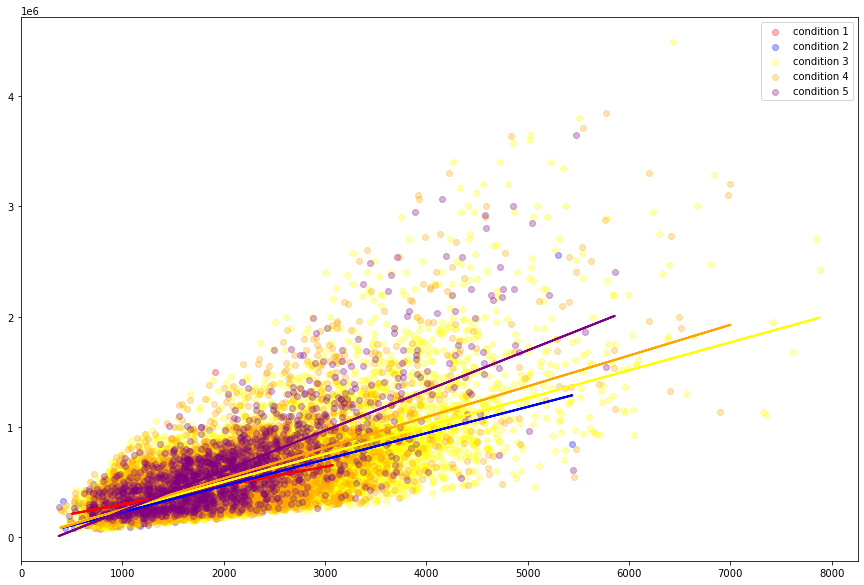

In [151]:
cond1=df[df.condition==1]
cond2=df[df.condition==2]
cond3=df[df.condition==3]
cond4=df[df.condition==4]
cond5=df[df.condition==5]

# get the values for sqft_living from the different cond dfs
sqft_1 = cond1.sqft_living.values.reshape(-1,1)
sqft_2 = cond2.sqft_living.values.reshape(-1,1)
sqft_3 = cond3.sqft_living.values.reshape(-1,1)
sqft_4 = cond4.sqft_living.values.reshape(-1,1)
sqft_5 = cond5.sqft_living.values.reshape(-1,1)

regression1 = LinearRegression()
regression2 = LinearRegression()
regression3 = LinearRegression()
regression4 = LinearRegression()
regression5 = LinearRegression()

# fit 
model1 = regression1.fit(sqft_1, cond1.price)
model2 = regression2.fit(sqft_2, cond2.price)
model3 = regression3.fit(sqft_3, cond3.price)
model4 = regression4.fit(sqft_4, cond4.price)
model5 = regression5.fit(sqft_5, cond5.price)

pred1 = model1.predict(sqft_1)
pred2 = model2.predict(sqft_2)
pred3 = model3.predict(sqft_3)
pred4 = model4.predict(sqft_4)
pred5 = model5.predict(sqft_5)


plt.clf()
plt.figure(figsize=(15,10))
plt.scatter(sqft_1, cond1.price, color='red', alpha=.3, label = 'condition 1')
plt.scatter(sqft_2, cond2.price, color='blue', alpha=.3, label = 'condition 2')
plt.scatter(sqft_3, cond3.price, color='yellow', alpha=.3, label = 'condition 3')
plt.scatter(sqft_4, cond4.price, color='orange', alpha=.3, label = 'condition 4')
plt.scatter(sqft_5, cond5.price, color='purple', alpha=.3, label = 'condition 5')
plt.plot(sqft_1, pred1, color = 'red', linewidth=2)
plt.plot(sqft_2, pred2, color = 'blue', linewidth=2)
plt.plot(sqft_3, pred3, color = 'yellow', linewidth=2)
plt.plot(sqft_4, pred4, color = 'orange', linewidth=2)
plt.plot(sqft_5, pred5, color = 'purple', linewidth=2)

plt.legend()
plt.show()

## sqft living and houses after 1970s 

In [ ]:
print(len(df[df.yr_built >= 1970]))

print(len(df[df.yr_built < 1970]))

df['after_seventy'] = df.yr_built.apply(lambda x: 1 if x >= 1970 else 0)

print(len(df[df.after_seventy == 1]))

df.head()

sns.lmplot(x = 'sqft_living',
          y= 'price',
          hue='after_seventy',
          data=df,
          fit_reg=False,
          height=8)

1693
21478
1693


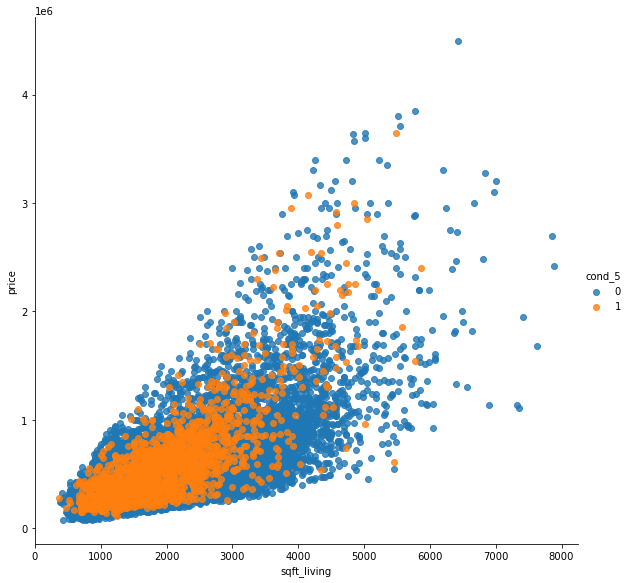

In [193]:
print(len(df[df.condition == 5]))
print(len(df[df.yr_built != 5]))

df['cond_5'] = df.condition.apply(lambda x: 1 if x == 5 else 0)
print(len(df[df.cond_5 == 1]))

sns.lmplot(x = 'sqft_living',
          y= 'price',
          hue='cond_5',
          data=df,
          fit_reg=False,
          height=8)

In [159]:
model = sm.OLS.from_formula('price ~ sqft_living + bathrooms + condition', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     6556.
Date:                Sun, 29 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:42:49   Log-Likelihood:            -2.9703e+05
No. Observations:               21478   AIC:                         5.941e+05
Df Residuals:                   21474   BIC:                         5.941e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.668e+05   1.07e+04    -15.587      0.000   -1.88e+05   -1.46e+05
sqft_living   264.3969      2.841     93.052      0.000     258.828     269.966
bathrooms    3303.4039   3392.874      0.974      0.330   -3346.881    9953.689
condition    4.336e+04   2596.897     16.698      0.000    3.83e+04    4.85e+04
==============================================================================
Omnibus:                    11366.033   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           160900.819
Skew:                           2.224   Prob(JB):                         0.00
Kurtosis:                      15.650   Cond. No.                     1.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:
model = sm.OLS.from_formula('price ~ sqft_living + bathrooms + condition + sqft_living:condition', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     5018.
Date:                Sun, 29 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:42:46   Log-Likelihood:            -2.9692e+05
No. Observations:               21478   AIC:                         5.939e+05
Df Residuals:                   21473   BIC:                         5.939e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.269e+05   2.28e+04      5.563      0.000    8.22e+04    1.72e+05
sqft_living             117.5210     10.479     11.215      0.000      96.981     138.061
bathrooms              2994.1458   3376.404      0.887      0.375   -3623.857    9612.149
condition             -4.394e+04   6530.814     -6.728      0.000   -5.67e+04   -3.11e+04
sqft_living:condition    43.9414      3.019     14.556      0.000      38.024      49.859
==============================================================================
Omnibus:                    11252.969   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           161131.383
Skew:                           2.190   Prob(JB):                         0.00
Kurtosis:                      15.684   Cond. No.                     1.14e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'waterfront'}>],
       [<AxesSubplot:title={'center':'sqft_living_scaled'}>,
        <AxesSubplot:title={'center':'price_log'}>]], dtype=object)

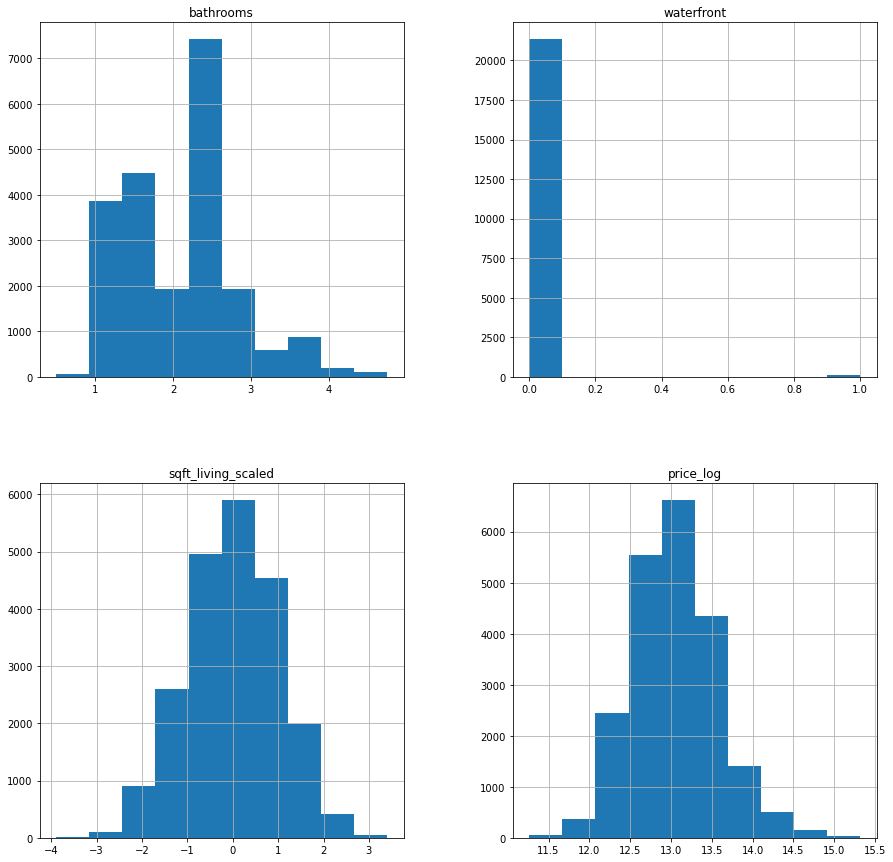

In [162]:
# log scale sqft livings and price - they are skewed 
df_log = pd.DataFrame()
df_log['sqft_living_log'] = np.log(df['sqft_living'])
df_log['price_log'] = np.log(df['price'])
# df_log['bathrooms_log'] = np.log(df['bathrooms']) 
# standardization on sqft_livings 
# mean normalization on grade and bathrooms 

from sklearn.preprocessing import Normalizer, StandardScaler
scaler = StandardScaler()
transformer = Normalizer()

df_scaled = pd.DataFrame()
df_scaled[['sqft_living_scaled']] = df_log[['sqft_living_log']]
df_scaled[['sqft_living_scaled']] = scaler.fit_transform(df_scaled[['sqft_living_scaled']])

features = ['bathrooms', 'waterfront']
df_final = pd.concat([df[features],df_scaled,df_log.price_log],axis=1)
df_final.columns
df_final.head()
df_final.hist(figsize=[15,15])

In [163]:
# MLR using price_log and all scaled features 
model = sm.OLS.from_formula('price_log ~ sqft_living_scaled + bathrooms + waterfront + sqft_living_scaled:waterfront', df_final).fit()
print(model.params)
print(model.rsquared) # grabs the rsquared value 
model.summary()

Intercept                        12.923673
sqft_living_scaled                0.310978
bathrooms                         0.054411
waterfront                        0.651319
sqft_living_scaled:waterfront     0.107366
dtype: float64
0.4617103131932525


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     4605.
Date:                Sun, 29 Aug 2021   Prob (F-statistic):               0.00
Time:                        15:42:07   Log-Likelihood:                -9765.3
No. Observations:               21478   AIC:                         1.954e+04
Df Residuals:                   21473   BIC:                         1.958e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        12.9237      0.012   1115.267      0.000      12.901      12.946
sqft_living_scaled                0.3110      0.004     77.794      0.000       0.303       0.319
bathrooms                         0.0544      0.005     10.133      0.000       0.044       0.065
waterfront                        0.6513      0.040     16.171      0.000       0.572       0.730
sqft_living_scaled:waterfront     0.1074      0.027      3.919      0.000       0.054       0.161
==============================================================================
Omnibus:                      132.629   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.513
Skew:                           0.102   Prob(JB):                     4.51e-24
Kurtosis:                       2.719   Cond. No.                         41.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

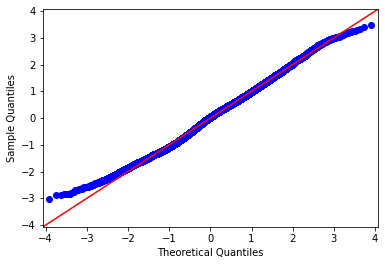

In [164]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

<Figure size 432x288 with 0 Axes>

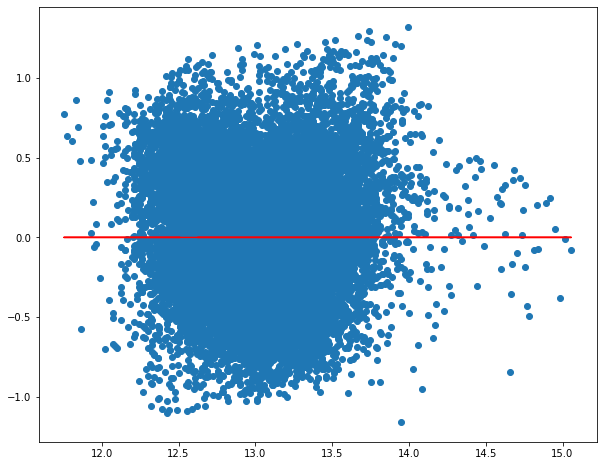

In [165]:
# homoskedasticity
fitted_values = model.predict()
residuals = df_final.price_log - fitted_values

plt.clf()
fig = plt.figure(figsize=(10,8))
# plt.scatter(fitted_values, residuals)
plt.scatter(model.fittedvalues, model.resid)
y_values = [0 for x in fitted_values]
plt.plot(fitted_values, y_values, color='red')

# Feature Selection

In [166]:
# feature selection
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [167]:
predictors = df_final.drop('price_log', axis=1)
result = stepwise_selection(predictors, df_final['price_log'], verbose=True)
print('resulting features:')
print(result)

Add  bathrooms                      with p-value 0.0
Add  sqft_living_scaled             with p-value 0.0
Add  waterfront                     with p-value 1.98635e-115
resulting features:
['bathrooms', 'sqft_living_scaled', 'waterfront']


In [168]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=4)
selector = selector.fit(predictors, df_final['price_log'])

In [169]:
selector.support_ 

array([ True,  True,  True])

In [170]:
# cross model validation 
# TODO then experiment with geographu
# TODO add bit about hypothesis testing
# TODO investigate an interaction with or without view 

In [171]:
df_final.columns

Index(['bathrooms', 'waterfront', 'sqft_living_scaled', 'price_log'], dtype='object')

# Model Validation Using sklearn 

In [172]:
from sklearn.model_selection import train_test_split
X = predictors
y = df_final['price_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print(len(X_train), len(X_test), len(y_train), len(y_test))


17182 4296 17182 4296


In [173]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)
y_hat_train = linreg.predict(X_train)

In [174]:
# calculate the residuals and the MSE of the test set 
# Root Mean Square Error is the standard deviation of the residuals(prediction errors)
# MSE is the average of the square of the errors.
# Error in this case means the difference between the observed values y1, y2, y3, … and the predicted ones pred(y1), pred(y2), pred(y3), 
from sklearn.metrics import mean_squared_error

test_residuals = y_hat_test - y_test
test_error = mean_squared_error(y_test, y_hat_test)
train_error = mean_squared_error(y_train, y_hat_train)
print(test_error)
print(train_error)

0.1408199481112635
0.14662978124958395


In [175]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error) 
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
cv_5_results.mean()

0.14563561994393615

In [176]:
cv_5_results

array([0.14816476, 0.14796168, 0.14621895, 0.15166542, 0.13416729])